In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm
from pathlib import Path

In [92]:
class Config:
    num_classes = 264
    batch_size = 12
    PRECISION = 16    
    seed = 2023
    model = "tf_efficientnet_b0_ns"
    pretrained = False
    use_mixup = False
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    data_root = "../data/"
    train_images = "../data/specs/train/"
    valid_images = "../data/specs/valid/"
    train_path = "../data/train.csv"
    valid_path = "../data/valid.csv"
    
    test_path = '../data/test_soundscapes/'
    SR = 32000
    DURATION = 5
    LR = 5e-4
    
    model_ckpt = '../src/exp1/last.ckpt'

In [93]:
pl.seed_everything(Config.seed, workers=True)

Seed set to 2023


2023

In [94]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [95]:
def compute_melspec(y, sr, n_mels, fmin, fmax):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [96]:
df_train = pd.read_csv(Config.train_path)
Config.num_classes = len(df_train.primary_label.unique())

In [97]:
# [(path.stem, *path.stem.split("_"), path) for path in Path(Config.test_path).glob("*.ogg")]

In [98]:
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(Config.test_path).glob("*.ogg")],
    columns = ["name" ,"id", "path"]
)
print(df_test.shape)
df_test.head()

(1, 3)


,name,id,path
0,727844024,727844024,../data/test_soundscapes/727844024.ogg


In [99]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [100]:
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile 

class BirdDataset(Dataset):
    def __init__(self, data, sr=Config.SR, n_mels=128, fmin=0, fmax=None, duration=Config.DURATION, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    
    def audio_to_image(self, audio):
        melspec = compute_melspec(audio, self.sr, self.n_mels, self.fmin, self.fmax) 
        image = mono_to_color(melspec)
        image = self.normalize(image)
        return image

    def read_file(self, filepath):
        audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return images
    
        
    def __getitem__(self, idx):
        return self.read_file(self.data.loc[idx, "path"])

In [101]:
ds_test = BirdDataset(
    df_test, 
    sr = Config.SR,
    duration = Config.DURATION,
)

In [102]:
ds_test[0].shape

(48, 3, 128, 313)

In [103]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds), num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img = img_ds[img_index][0]   
        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

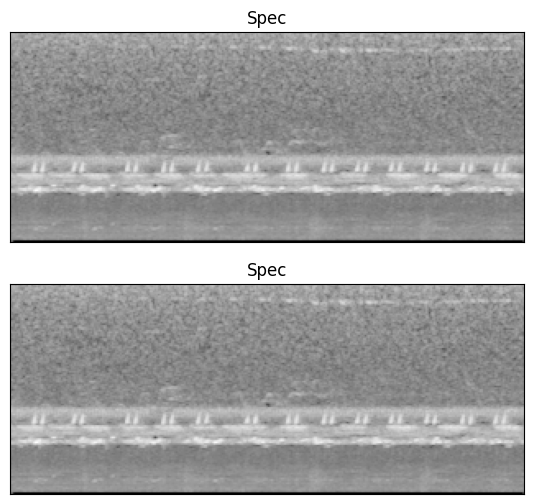

In [104]:
show_batch(ds_test, 2, 2, 1)

In [105]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [106]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [107]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def training_step(self, batch, batch_idx):
        image, target = batch        

        y_pred = self(image)
        loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    

In [108]:
def predict(data_loader, model):
        
    model.to('cpu')
    model.eval()    
    predictions = []
    for en in range(len(ds_test)):
        print(en)
        images = torch.from_numpy(ds_test[en])
        print(images.shape)
        with torch.no_grad():
            outputs = model(images).sigmoid().detach().cpu().numpy()
            print(outputs.shape)
#             pred_batch.extend(outputs.detach().cpu().numpy())
#         pred_batch = np.vstack(pred_batch)
        predictions.append(outputs)
            
    
    return predictions

In [109]:
import gc

print(f"Create Dataloader...")

ds_test = BirdDataset(
    df_test, 
    sr = Config.SR,
    duration = Config.DURATION,
)


audio_model = BirdClefModel()

print("Model Creation")

model = BirdClefModel.load_from_checkpoint(Config.model_ckpt, train_dataloader=None,validation_dataloader=None) 
print("Running Inference..")

preds = predict(ds_test, model)   

gc.collect()
torch.cuda.empty_cache()

Create Dataloader...
Model Creation
Running Inference..
0
torch.Size([48, 3, 128, 313])
(48, 182)


In [110]:
filenames = df_test.name.values.tolist()

bird_cols = list(pd.get_dummies(df_train['primary_label']).columns)
sub_df = pd.DataFrame(columns=['row_id']+bird_cols)

In [111]:
sub_df

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


In [112]:
for i, file in enumerate(filenames):
    pred = preds[i]
    num_rows = len(pred)
    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+bird_cols)
    
    df['row_id'] = row_ids
    df[bird_cols] = pred
    
    sub_df = pd.concat([sub_df,df]).reset_index(drop=True)

In [113]:
sub_df

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,727844024_5,0.322196,0.356147,0.402754,0.302794,0.369778,0.386276,0.313689,0.336061,0.370838,...,0.357324,0.382384,0.387095,0.389105,0.515872,0.556474,0.354229,0.406983,0.317293,0.586611
1,727844024_10,0.379993,0.405834,0.440367,0.354138,0.410436,0.410904,0.365622,0.389998,0.428420,...,0.378030,0.418291,0.443709,0.410509,0.491067,0.513284,0.405190,0.435297,0.387803,0.562066
2,727844024_15,0.399281,0.417088,0.442680,0.363018,0.428698,0.409790,0.380313,0.403753,0.438511,...,0.402375,0.432649,0.452251,0.430998,0.504558,0.496146,0.424446,0.447908,0.406652,0.546668
3,727844024_20,0.329351,0.339707,0.390219,0.298661,0.360287,0.357998,0.304275,0.313193,0.373817,...,0.334231,0.365779,0.402859,0.370010,0.523621,0.535050,0.356177,0.379115,0.318796,0.592655
4,727844024_25,0.347602,0.347657,0.420372,0.337607,0.359097,0.376762,0.329512,0.348441,0.377433,...,0.339601,0.355995,0.409702,0.385358,0.501086,0.536474,0.367122,0.382030,0.323432,0.592929
5,727844024_30,0.366839,0.399016,0.442468,0.361662,0.416153,0.403024,0.371070,0.400264,0.422450,...,0.378048,0.409438,0.454365,0.415546,0.485092,0.524035,0.403819,0.433548,0.373032,0.544277
6,727844024_35,0.420697,0.420961,0.462105,0.394328,0.446133,0.423024,0.407394,0.416317,0.445918,...,0.407587,0.446033,0.471319,0.441675,0.483560,0.498404,0.425006,0.472121,0.390272,0.527914
7,727844024_40,0.354506,0.375000,0.420408,0.331129,0.399087,0.385301,0.357278,0.365966,0.419380,...,0.374717,0.401585,0.448475,0.394718,0.502067,0.533962,0.379194,0.412404,0.349729,0.549977
8,727844024_45,0.360082,0.386673,0.429576,0.334124,0.394399,0.406380,0.344104,0.380234,0.385518,...,0.364687,0.412205,0.407358,0.415027,0.528444,0.496692,0.390507,0.419729,0.361816,0.551752
9,727844024_50,0.370514,0.390336,0.442778,0.346070,0.386607,0.386662,0.356802,0.395888,0.396067,...,0.385055,0.438222,0.430468,0.394104,0.496677,0.506061,0.392059,0.434077,0.368238,0.570616


In [114]:
sub_df.to_csv('submission.csv',index=False)